<ins>Logical Workflow PA Project</ins>

0. Call Data from SQL Server and save to local .pkl. Filter by TBM 1 and time span ('2022/02/01', '2022/04/01')
1. Join data for a complete dataset
2. Initial drop duplicates, Filter (by Equipment ID: TBM 1 and remove Trial Recipes), key generation, cycle time generation and EDA
3. Left Merge Alarm mapping and Alarm hisroy on Created Key.
4. Alarm Discovery: Alarm to GT allocation: Calculate PAAP start and finish times if needed. Do NOT Filter alarms by Type e.g.  FF, CF and MC, assin name in#dexes. Link these alarm name indexes that are occurring for the same green tire at those times identified as PA. Create GT to Alarm Index Mapping.
5. One Hot encode Alarm Indexes before we carry out feature selction to see relevant alarms.
6. Feature selection: Initial Filter using statistical univariate filter methods. 
7. Feature selection: Narrow down using ML Models. Identify which steps are posing the issue (i.e. is it sidewall, inner liner, is it transport time etc.)
8. View Selected Alarms and Discuss with Operations Team
9. With an Alarm, classifed the GT's which had this alarm (allocated on entire start/produced time instead). We then join the alarm mapping with alarm history and join this table to the GT's in production data and perform counts and validate apparent erroneous durations. Sort the alarms into 'Errors' and 'Valid'. i.e. Alarm Duration < PAAP & Cycle Time is a Valid Scenario. Errors are EITHER Alarm Duration > PAAP OR Alarm Duration > PAAP & Cycle Time
    Have decided to take the subset of Duration < Cycle Time as GT's that make feasible sense.
10. Carry out More detailed analysis to gauge size of the prize. Here we have taken the 95th percentile of cycle times to remove outlier GT's. We had already previously removed Trial Recipes. Then:
    •	Analyse if they have taken each alarm once or twice. Need to sort by Null i.e. (Mahesh is handling)
    •	Count of 'Valid' Alarms. Calculate percentage out of all GT's Produced 
    •	Recalculate time saving per cycle time for start_time and ProducedOn Time. i.e. Redo Allocation of GT's
    •	See Date dependence of PA alarms. (one day may be particularly bad due to converyor belt issue, or Recipe   inherent etc.) (Automation Conveyor may have an issue on one particylar day). See if Date Dependent
11. Continuation of 10, to carry out more detailed analysis to gauge size of the prize
    •	See correlation coeff with Duration and Cycle time/PAAP time
    •	General Analysis of PAAP Times
    •	Check next and previous tyres for the Errors.   
    •	Investigate for other TBM's
12.	Plot these comparisons and highlight your observations. Add any other analysis as we go along: 
    •	Total CT variation - m/c wise
    •	CT variation - application wise
    •	Total CT variation - Diameter wise
    •	Total CT variation - Recipe wise
    •	Number of changeovers - m/c wise 
    •	Number of changeovers - due to recipe, due to diameter

In [1]:
import pandas as pd
from helpers import TBM, bcolors, Feature_Selection, Data_Functions
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

TBM = TBM()
p = bcolors()
FS = Feature_Selection()
DF = Data_Functions()

In [2]:
df_tbm = pd.read_pickle("./pkl/df_tbm_master.pkl")

In [3]:
df_tbm = TBM.rename_df(df_tbm)
df_tbm = TBM.cycle_time_looper(df_tbm)
df_tbm.head()

,ProducedOn,EquipmentID,ProductionDataId,UserGroupName,Name_of_Active_Operator,RecipeName,Name_of_Active_Production_Order,date/time,Barcode_on_build_tire,GT_Code_of_the_built_tire,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_RS,VRL_VHMC_MES_CCPR_CYCLE_TIME_BDSG,VRL_VHMC_MES_CCPR_CYCLE_TIME_RLCY,VRL_VHMC_MES_CCPR_CYCLE_TIME_SHAPE,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s
0,2022-02-01 06:01:51,TBM 10,1037264,Operator,Operator 043,GG224517ULAXY,T22060000700,20220201 06:01:51,0013635349,GG224517ULAXY,...,0.0,1.456,4.379,6.876,5.927,0.0,2.555,11141532,2022-02-01 06:00:40,71
1,2022-02-01 06:02:36,TBM 10,1037265,Operator,Operator 043,GG224517ULAXY,T22060000700,20220201 06:02:36,0013635350,GG224517ULAXY,...,0.0,1.452,4.609,7.040,5.965,0.0,2.591,11141533,2022-02-01 06:01:51,45
2,2022-02-01 06:03:16,TBM 10,1037266,Operator,Operator 043,GG224517ULAXY,T22060000700,20220201 06:03:16,0013635351,GG224517ULAXY,...,0.0,1.453,4.449,6.905,6.067,0.0,2.576,11141534,2022-02-01 06:02:36,40
3,2022-02-01 06:03:57,TBM 10,1037267,Operator,Operator 043,GG224517ULAXY,T22060000700,20220201 06:03:57,0013635352,GG224517ULAXY,...,0.0,1.448,4.408,6.819,5.947,0.0,2.590,11141624,2022-02-01 06:03:16,41
4,2022-02-01 06:04:37,TBM 10,1037268,Operator,Operator 043,GG224517ULAXY,T22060000700,20220201 06:04:37,0013635353,GG224517ULAXY,...,0.0,1.458,4.612,6.871,6.021,0.0,2.519,11141625,2022-02-01 06:03:57,40


In [9]:
df_tbm.columns.to_list()

['ProducedOn',
 'EquipmentID',
 'ProductionDataId',
 'UserGroupName',
 'Name_of_Active_Operator',
 'RecipeName',
 'Name_of_Active_Production_Order',
 'date/time',
 'Barcode_on_build_tire',
 'GT_Code_of_the_built_tire',
 'Actual_Weight_of_GT_(written_by_MES)',
 'Minimum_allowed_Weight_of_GT',
 'Maximum_allowed_Weight_of_GT',
 'Material_Code_of_Breaker_1_Material',
 'Cartridge_RFID_of_Breaker_1_Material_(_C:ette_RFID_Code)',
 'Material_Status_of_Breaker_1_Material_(0_NOT_OK_1_OK)',
 'VRL_VHMC_MES_1BCU_TEMP_MEASURED',
 'Breaker_1_Me:ured_Width_by_VVS_(_by_camera)',
 'VRL_VHMC_MES_BR1_WIDTH_MEASURED',
 'Breaker_1_Width_Setpoint',
 'VRL_VHMC_MES_BR1_LENGTH_MEASURED',
 'Breaker_1_Length_Setpoint',
 'VRL_VHMC_MES_BR1_LE_ANGLE_MEASURED',
 'VRL_VHMC_MES_BR1_TE_ANGLE_MEASURED',
 'Breaker_1_Angle_Setpoint',
 'Breaker_1_Pos_Width_OK_by_VVS(_by_camera)',
 'VRL_VHMC_MES_BR1_MEAS_LENGTH_AXIS',
 'Breaker_1_Use_VVS_Length_length_for_stretching',
 'Breaker_1_Spot_Position',
 'Breaker_1_Cycle_time_Homing

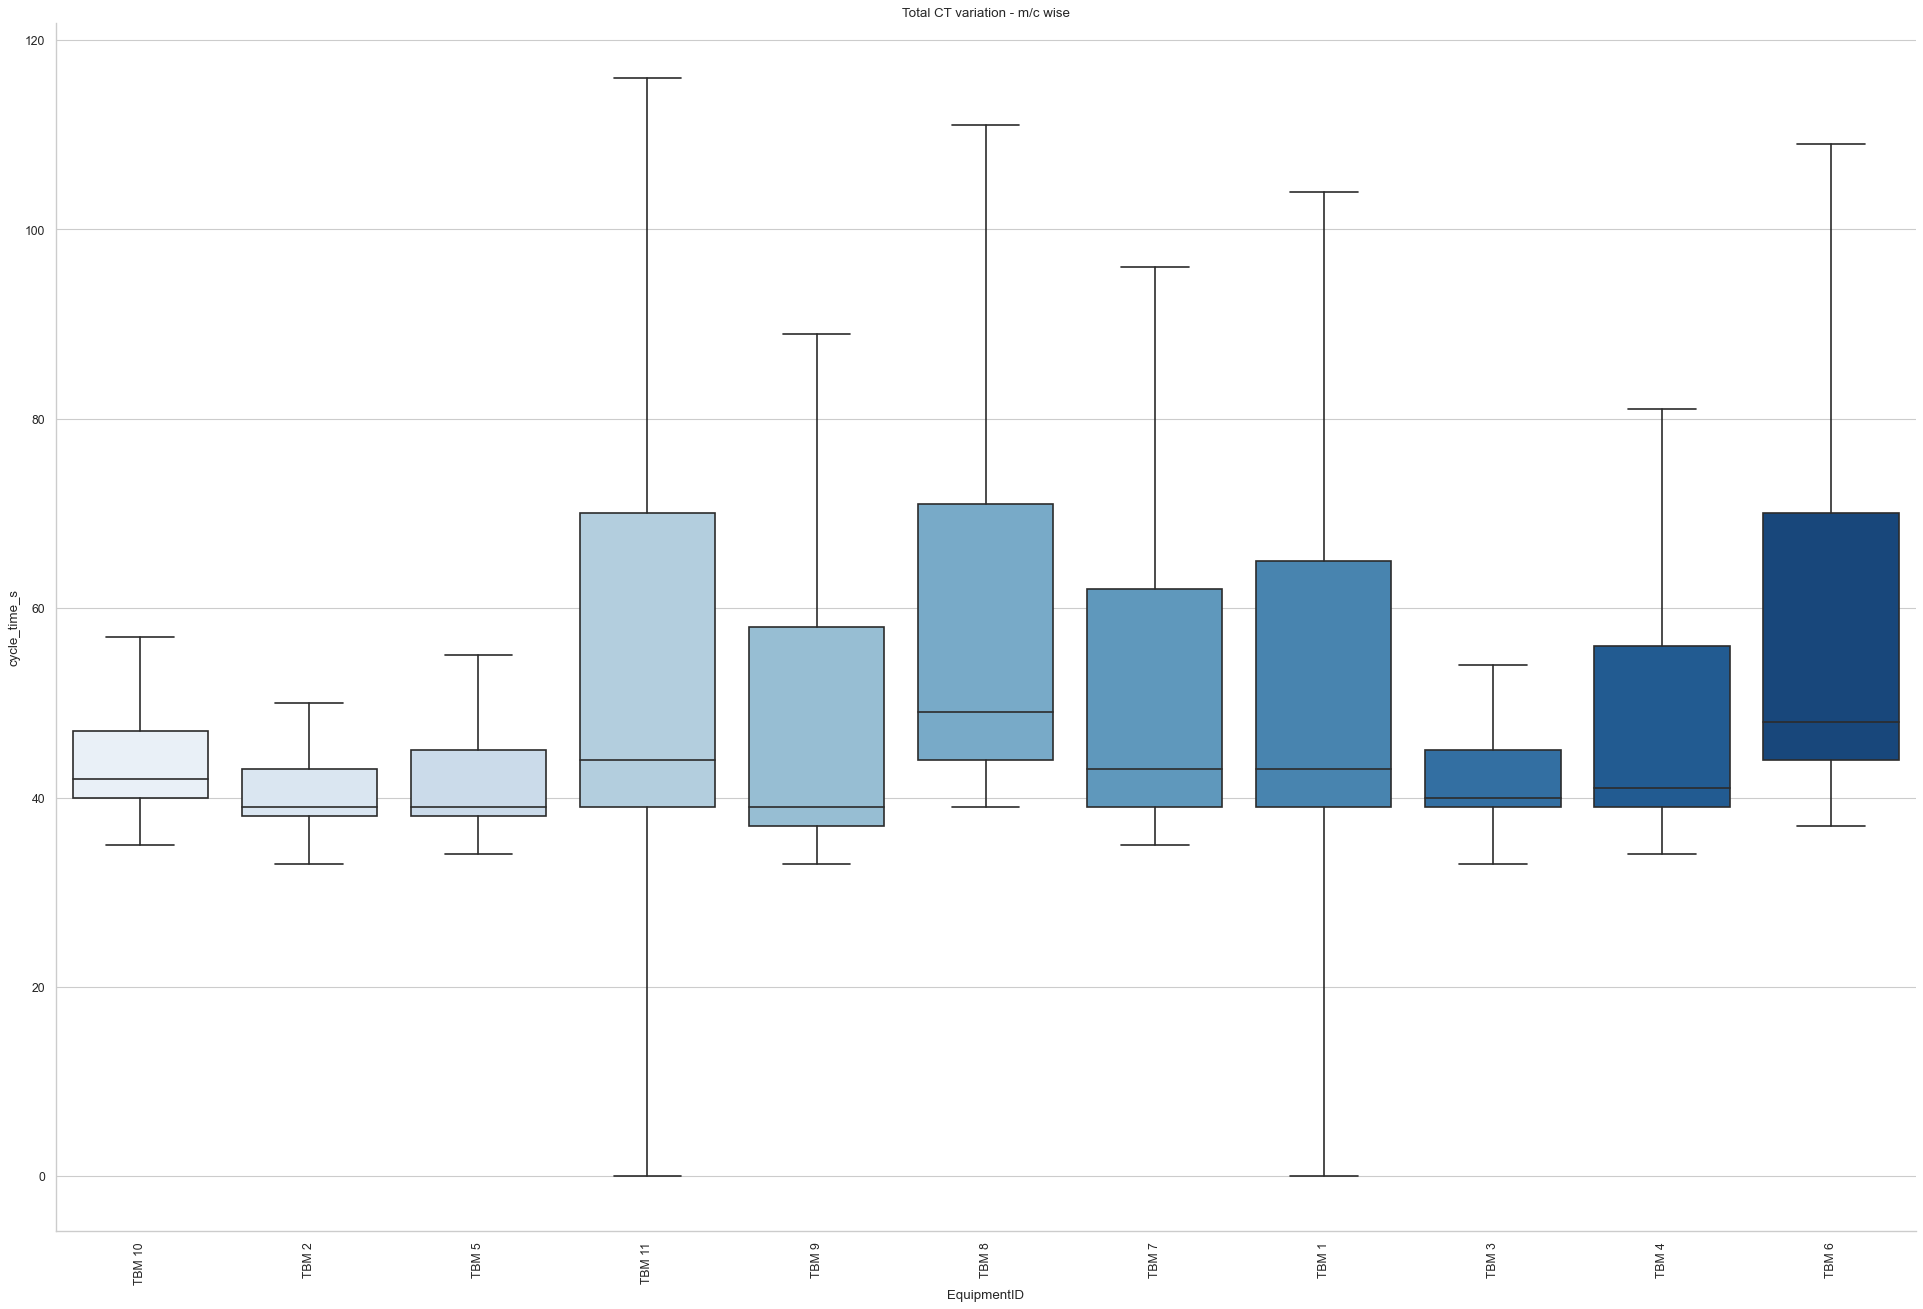

In [21]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(30, 20), dpi=80)
# Draw a nested boxplot to show Corrected and uncorrected times by Date
sns.boxplot(x="EquipmentID", y="cycle_time_s",
            # hue="corrected", palette=["r", "g"],
            palette="Blues",
            data=df_tbm, showfliers = False)
plt.title('Total CT variation - m/c wise')
plt.xticks(rotation = 90)
sns.despine(left=False)

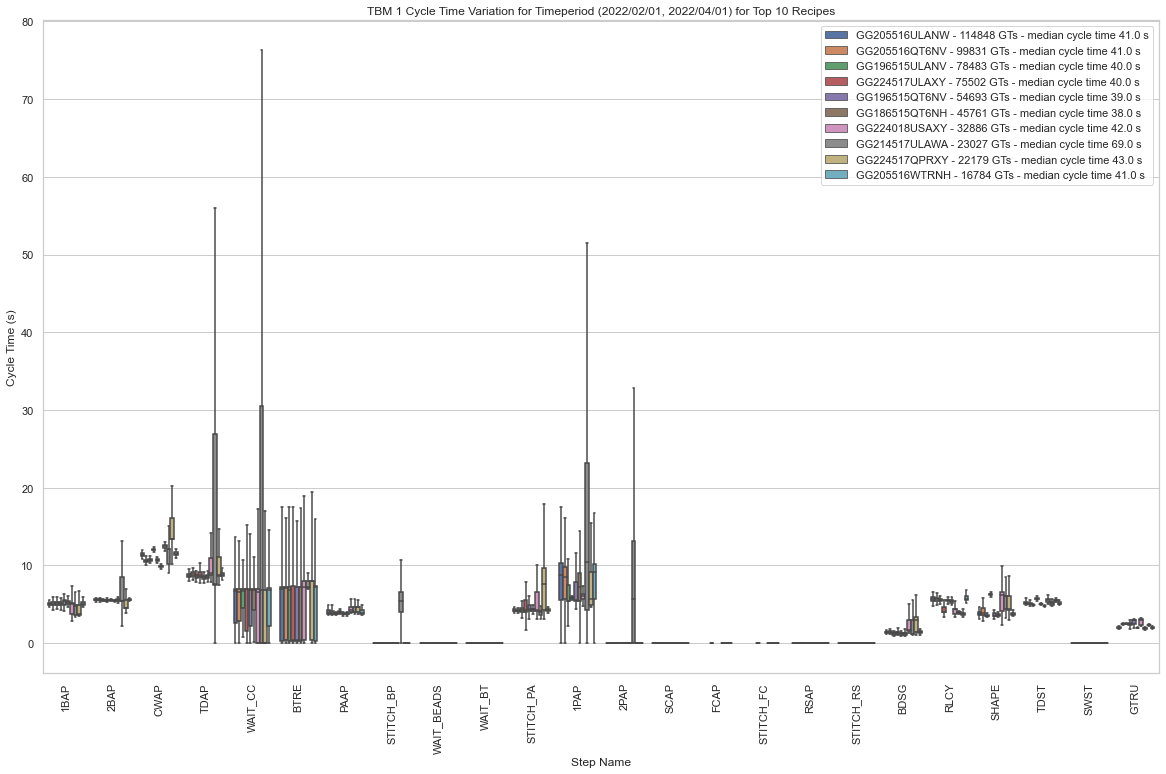

In [22]:
top10recipe = df_tbm.groupby('RecipeName').count().ProducedOn.sort_values(ascending=False).head(10).index.tolist()

keep_cols = [
'VRL_VHMC_MES_BTPR_CYCLE_TIME_1BAP',
'VRL_VHMC_MES_BTPR_CYCLE_TIME_2BAP',
'VRL_VHMC_MES_BTPR_CYCLE_TIME_CWAP',
'VRL_VHMC_MES_BTPR_CYCLE_TIME_TDAP',
'VRL_VHMC_MES_BTPR_CYCLE_TIME_WAIT_CC',
'VRL_VHMC_MES_BTPR_CYCLE_TIME_BTRE',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_BP',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BEADS',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BT',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_PA',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_1PAP',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_2PAP',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_SCAP',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_FCAP',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_FC',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_RSAP',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_RS',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_BDSG',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_RLCY',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_SHAPE',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU',
]

rename_dict = {}

for col in keep_cols:
    rename_dict[col] = col.split('CYCLE_TIME_')[1]

rename_dict
melted = pd.DataFrame()
for recipe in top10recipe:
    df_r = df_tbm[df_tbm.RecipeName == recipe]
    median_ct = df_r.cycle_time_s.median()
    df_r = df_r[keep_cols]
    df_r.rename(columns=rename_dict, inplace=True)
    df_melt = pd.melt(df_r)
    df_melt['RecipeName'] = f'{recipe} - {df_r.shape[0]} GTs - median cycle time {median_ct} s'
    if melted.empty:
        melted = df_melt
    else: 
        melted = pd.concat([melted, df_melt])
df_melt
melted['value'] = melted['value'].astype(float)
f, ax = plt.subplots(figsize=(20, 12))
plt.xticks(rotation=90)
sns.boxplot(x = melted['variable'],
            y = melted['value'],
            hue = melted['RecipeName'],
            showfliers=False)
plt.ylabel('Cycle Time (s)')
plt.title(f'TBM 1 Cycle Time Variation for Timeperiod (2022/02/01, 2022/04/01) for Top {len(top10recipe)} Recipes')
plt.xlabel('Step Name')
plt.legend(facecolor='white')
plt.show()